In [ ]:
from keybert import KeyBERT
import json
import pandas as pd
import concurrent.futures
from sentence_transformers import SentenceTransformer

top_n_vals = [5, 10, 50, 100, 500, 1000]

cranfield = []
with open("cranfield/cran_docs.json", "r") as f:
    cranfield = json.load(f)

body_list = [data['body'] for data in cranfield]
combined_text = " ".join(body_list)

# Load the model and tokenizer explicitly
model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

def get_keywords(text, top_n, model):
    # Initialize KeyBERT with the loaded model
    kw_model = KeyBERT(model=model)

    # Extract keywords
    keywords = kw_model.extract_keywords(
        text,
        keyphrase_ngram_range=(1, 1),
        stop_words="english",
        use_mmr=True,
        top_n=top_n
    )

    # Save keywords to a CSV file
    df = pd.DataFrame(keywords, columns=['Keyword', 'Score'])
    df.to_csv(f"topics/topics_top_{top_n}.csv", index=False)
    return None


with concurrent.futures.ThreadPoolExecutor() as executor:
    # Extract keywords in parallel
    keyword_results = list(executor.map(get_keywords, [combined_text]*len(top_n_vals), top_n_vals, [model]*len(top_n_vals)))


c:\Users\shrey\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
import requests
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, filename='wiki_summary.log', filemode='w',
                    format='%(asctime)s - %(levelname)s - %(message)s')

def get_wikipedia_summary(keyword, max_attempts=3):
    headers = {'User-Agent': 'NLP IR agent'}
    search_url = "https://en.wikipedia.org/w/api.php"

    # Search Wikipedia for the keyword
    search_params = {
        'action': 'query',
        'list': 'search',
        'srsearch': keyword,
        'format': 'json'
    }
    search_response = requests.get(search_url, params=search_params, headers=headers)
    search_data = search_response.json()

    search_hits = search_data.get('query', {}).get('search', [])

    # Try multiple hits (up to max_attempts)
    for idx, hit in enumerate(search_hits[:max_attempts]):
        title = hit['title']

        # Get the summary
        summary_params = {
            'action': 'query',
            'prop': 'extracts|categories',
            'exintro': True,
            'explaintext': True,
            'titles': title,
            'format': 'json'
        }
        summary_response = requests.get(search_url, params=summary_params, headers=headers)
        summary_data = summary_response.json()

        pages = summary_data.get('query', {}).get('pages', {})
        if pages:
            page = next(iter(pages.values()))
            summary = page.get('extract')
            categories = [cat['title'] for cat in page.get('categories', [])] if 'categories' in page else []

            # Check for disambiguation indicators
            if summary:
                is_disambig = ("disambiguation pages" in " ".join(categories).lower() or
                               "may refer to" in summary.lower() or
                               "may stand for" in summary.lower())

                if not is_disambig:
                    # Good summary found
                    logging.info(f"Found summary for '{keyword}'")  # Print first 100 characters
                    return summary
                else:
                    logging.info(f"Disambiguation detected for '{title}', trying next result...")

    # Fallback to dictionary definition
    synsets = wordnet.synsets(keyword)
    if synsets:
        return synsets[0].definition()

    return None

lemmatizer = WordNetLemmatizer()

for i in top_n_vals:

    df = pd.read_csv(f"topics/topics_top_{i}.csv")
    df['Keyword'] = df['Keyword'].apply(lambda x: lemmatizer.lemmatize(x))
    df.to_csv(f"topics/topics_top_{i}_lem.csv", index=False)

    # Get Wikipedia summaries in parallel
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Extract Wikipedia summaries in parallel
        wiki_results = list(executor.map(get_wikipedia_summary, df['Keyword']))

    # Save Wikipedia summaries to a json
    wiki_summaries = {df['Keyword'][i]: wiki_results[i]
                      for i in range(len(wiki_results))
                      if wiki_results[i] is not None}
    with open(f"topics/topics_top_{i}_lem_wiki.json", "w") as f:
        json.dump(wiki_summaries, f, indent=4)

In [ ]:
import json
import logging
import pandas as pd
import numpy as np
import re
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
#import wikipediaapi
from nltk.corpus import stopwords

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", filename="debug.log")
logger = logging.getLogger(__name__)

def preprocess_text(text):

    '''
    Preprocess the text by tokenizing, removing stop words, and lemmatizing.
    Args:
        text (str): The input text to preprocess.
    Returns:
        str: The preprocessed text.
    '''

    # Ensure nltk data is available when called by the Spark job later.
    import nltk
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    nltk.data.path.append("./nltk_data")

    if not text:
        return ""
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word for word in tokens if word not in stopwords.words("english")]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return " ".join(tokens)  # Return as a string

def clean_text(text):
    '''
    Clean the text by removing non-alphanumeric characters and converting to lowercase.
    (helper function)
    '''
    text = re.sub(r"\W+", " ", text.lower())
    text = re.sub(r"\s+", " ", text).strip()
    return text


def load_corpus(corpus_file="topics/topics_top_1000_lem_wiki.json"):
    '''
    Load the corpus from a JSON file.
    Args:
        corpus_file (str): Path to the JSON file containing the corpus.
    Returns:
        dict: The loaded corpus as a dictionary.
    '''

    try:
        with open(corpus_file, "r") as file:
            corpus_dict = json.load(file)
        logger.info(f"Corpus successfully loaded from {corpus_file}.")
        return corpus_dict
    except Exception as e:
        logger.error(f"Failed to load corpus from {corpus_file}: {e}")
        return {}


def generate_esa_vectors(text, corpus_file="topics/topics_top_1000_lem_wiki.json"):
    '''
    Generate ESA vectors for the given text using the lemmatized corpus.
    Args:
        text (str): The input text to generate ESA vectors for.
    Returns:
        list: The ESA vectors for the input text.
    '''

    logger.info("Generating ESA vectors.")

    corpus = load_corpus(corpus_file)  # Load the corpus
    if not corpus:
        logger.error("Corpus is empty or could not be loaded.")
        return [], []

    # preprocessing
    sentences = sent_tokenize(text)
    processed_sentences = [preprocess_text(s) for s in sentences]
    processed_corpus = list(corpus.values())
    all_documents = processed_sentences + processed_corpus

    vectorizer = TfidfVectorizer(stop_words="english")          # Create a TF-IDF vectorizer
    tfidf_matrix = vectorizer.fit_transform(all_documents)      # Fit and transform the documents

    esa_vectors = []
    # Generate ESA vectors for each processed sentence
    for i in range(len(processed_sentences)):
        similarities = cosine_similarity(tfidf_matrix[i:i+1], tfidf_matrix[len(processed_sentences):])
        esa_vector = similarities.flatten()
        esa_vectors.append(esa_vector)

    if esa_vectors:         # ESA vectors are generated
        esa_vectors = np.mean(esa_vectors, axis=0)
        return esa_vectors.tolist()
    else:
        logger.error("No ESA vectors generated.")
    return []

def main():
    '''
    Main function to run the ESA vector generation.
    '''
    # Example text
    text = "what are the structural and aeroelastic problems associated with flight of high speed aircraft ."

    # Generate ESA vectors for the example text
    esa_vectors = generate_esa_vectors(text, corpus_file="topics/topics_top_100_lem_wiki.json")

    if esa_vectors:
        print("ESA Vectors generated successfully.")
        print(esa_vectors)
    else:
        print("Failed to generate ESA vectors.")

if __name__ == "__main__":
    main()

ESA Vectors generated successfully.
[0.04342979505589475, 0.04640800668249069, 0.0, 0.027954005902964922, 0.02406387250442451, 0.0, 0.0, 0.0, 0.0, 0.023044563654779124, 0.0, 0.07062269908285612, 0.0, 0.0, 0.0, 0.01799739009632362, 0.0, 0.0, 0.1082423997033001, 0.07941038983369746, 0.0, 0.12156259885002085, 0.015615036318567189, 0.0, 0.0, 0.0, 0.0, 0.00880664186339722, 0.0235845400496438, 0.0, 0.0, 0.0, 0.008940808214708001, 0.0, 0.011389587661507413, 0.0, 0.02406387250442451, 0.007244661688261004, 0.022435669909016204, 0.0, 0.026115014533331985, 0.022265397962379443, 0.0, 0.0, 0.03292030801921773, 0.0, 0.0, 0.0, 0.0, 0.01707111308782621, 0.0, 0.0, 0.0, 0.0, 0.04798261594986034, 0.031591763781367875, 0.0, 0.008237621245766666, 0.029253269937733938, 0.07069755830099819, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05769821765074466, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01276409730331843, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
cranfield = []
with open("cranfield/cran_docs.json", "r") as f:
    cranfield = json.load(f)
    f.close()
bodies = {data['id']:data['body'] for data in cranfield}

corpus_sizes = [5, 10, 50, 100, 500, 1000]

In [ ]:
from collections import defaultdict

for corpus_size in corpus_sizes:

    esa_dict = defaultdict()

    for doc_id, doc_body in bodies.items():
        esa_dict[doc_id] = generate_esa_vectors(doc_body, corpus_file=f"topics/topics_top_{corpus_size}_lem_wiki.json")

    with open(f"topics/topics_top_{corpus_size}_docs_esa.json", "w") as f:
        json.dump(esa_dict, f)

KeyboardInterrupt: 

In [ ]:
import json
import numpy as np

class ESAInformationRetrieval:

    def __init__(self, corpus_size=1000):

        self.corpus_size = corpus_size
        self.docIDs = []
        self.docVectors = None

    def build_vectors(self):

        with open(f"topics/topics_top_{self.corpus_size}_docs_esa.json", "r") as f:
            doc_esa_vectors = json.load(f)
            f.close()
        self.docIDs = [int(doc_id) for doc_id in doc_esa_vectors.keys()]
        self.docVectors = np.array([x for x in list(doc_esa_vectors.values()) if len(x) != 0])

    def rank(self, query):

        queryVector = generate_esa_vectors(query, corpus_file=f"topics/topics_top_{self.corpus_size}_lem_wiki.json")

        sim_matrix = cosine_similarity(np.array(queryVector).reshape(1, -1), self.docVectors)

        for row in sim_matrix:
            ranked_indices = np.argsort(-row)
            ranked_docIDs = [self.docIDs[i] for i in ranked_indices]

        return ranked_docIDs

In [ ]:
ir = ESAInformationRetrieval(corpus_size=10)

In [ ]:
ir.build_vectors()

In [ ]:
queries_json = json.load(open("cranfield/cran_queries.json", 'r'))
qrels = json.load(open("cranfield/cran_qrels.json", 'r'))

In [ ]:
query_ids, queries = [item["query number"] for item in queries_json], [item["query"] for item in queries_json]

In [ ]:
from evaluation import Evaluation

evaluator = Evaluation()

In [ ]:
doc_IDs_ordered = [ir.rank(query) for query in queries]

precisions, recalls, fscores, MAPs, nDCGs = [], [], [], [], []

for k in range(1, 11):
    precision = evaluator.meanPrecision(doc_IDs_ordered, query_ids, qrels, k)
    precisions.append(precision)
    recall = evaluator.meanRecall(doc_IDs_ordered, query_ids, qrels, k)
    recalls.append(recall)
    fscore = evaluator.meanFscore(doc_IDs_ordered, query_ids, qrels, k)
    fscores.append(fscore)
    print("Precision, Recall and F-score @ " + str(k) + " : " + str(precision) + ", " + str(recall) + ", " + str(fscore))
    MAP = evaluator.meanAveragePrecision(doc_IDs_ordered, query_ids, qrels, k)
    MAPs.append(MAP)
    nDCG = evaluator.meanNDCG(doc_IDs_ordered, query_ids, qrels, k)
    nDCGs.append(nDCG)
    print("MAP, nDCG @ " + str(k) + " : " + str(MAP) + ", " + str(nDCG))



Precision, Recall and F-score @ 1 : 0.017777777777777778, 0.0023703703703703703, 0.004114959114959115
MAP, nDCG @ 1 : 0.0023703703703703703, 0.017777777777777778
Precision, Recall and F-score @ 2 : 0.013333333333333334, 0.003116402116402116, 0.004843863471314452
MAP, nDCG @ 2 : 0.0027433862433862435, 0.023386042253968512
Precision, Recall and F-score @ 3 : 0.011851851851851851, 0.003857142857142857, 0.005549548355749905
MAP, nDCG @ 3 : 0.0030890652557319224, 0.02525146798351601
Precision, Recall and F-score @ 4 : 0.011111111111111112, 0.004462081128747795, 0.005977938890219592
MAP, nDCG @ 4 : 0.003268077601410935, 0.027254435691556316
Precision, Recall and F-score @ 5 : 0.010666666666666668, 0.007573192239858907, 0.007700497033830368
MAP, nDCG @ 5 : 0.0038902998236331567, 0.03069312731141891
Precision, Recall and F-score @ 6 : 0.013333333333333334, 0.010736331569664904, 0.010633966677444937
MAP, nDCG @ 6 : 0.004491563786008231, 0.03871986939471226
Precision, Recall and F-score @ 7 : 0.

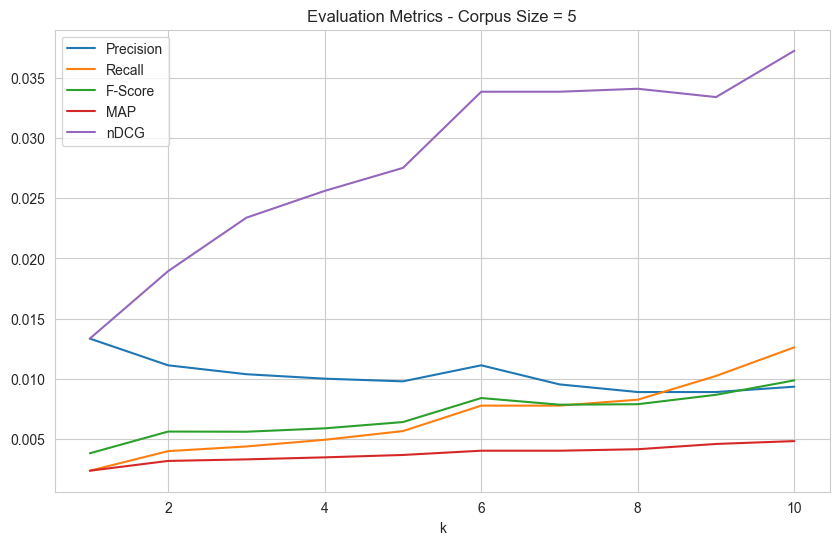

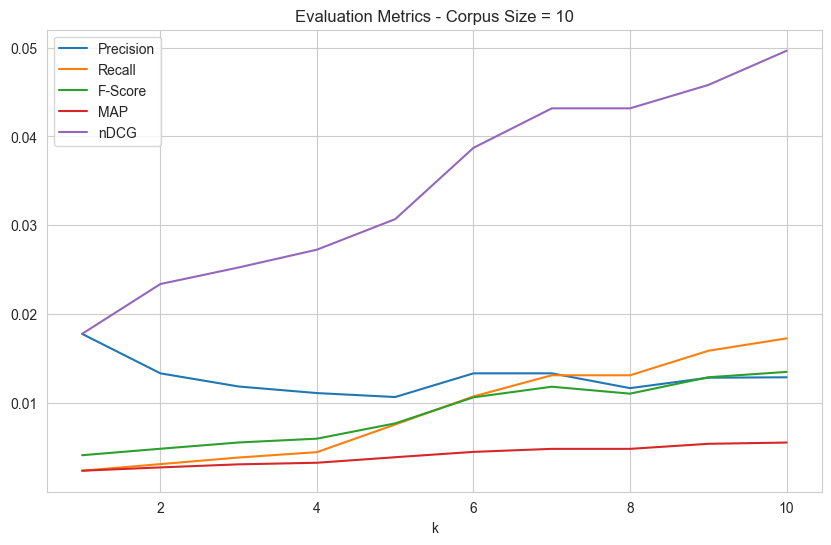

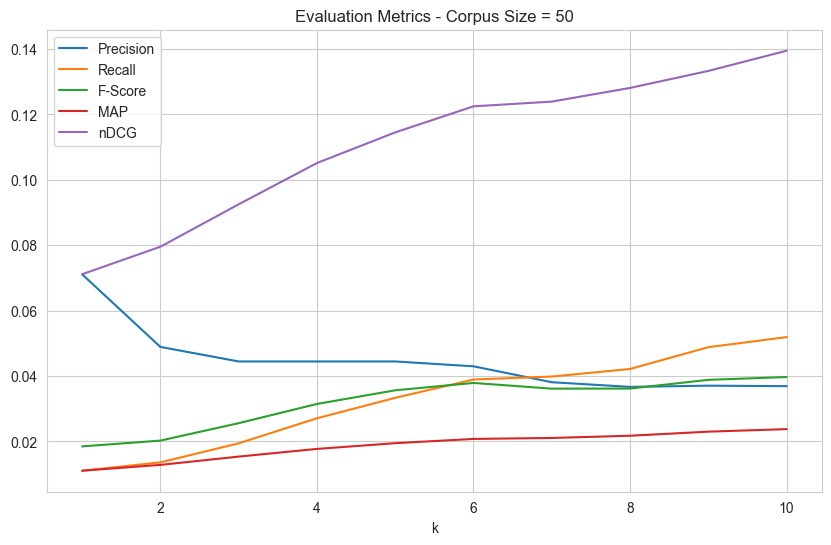

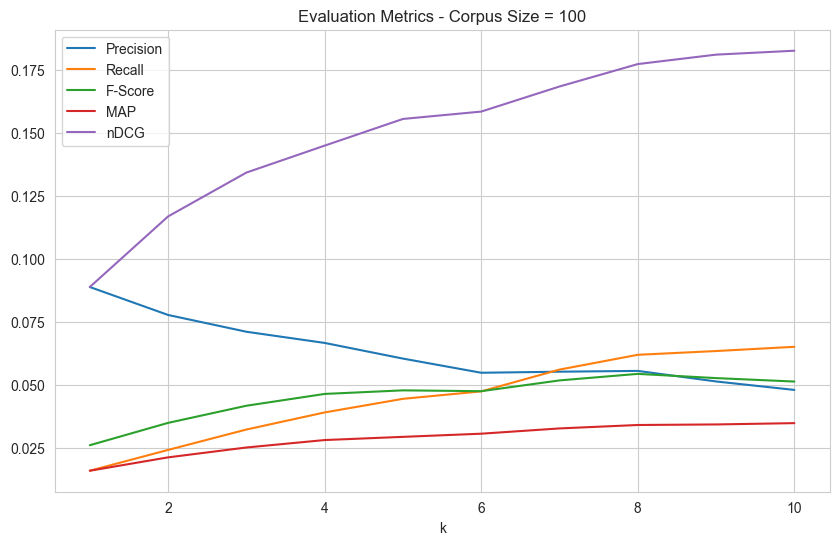

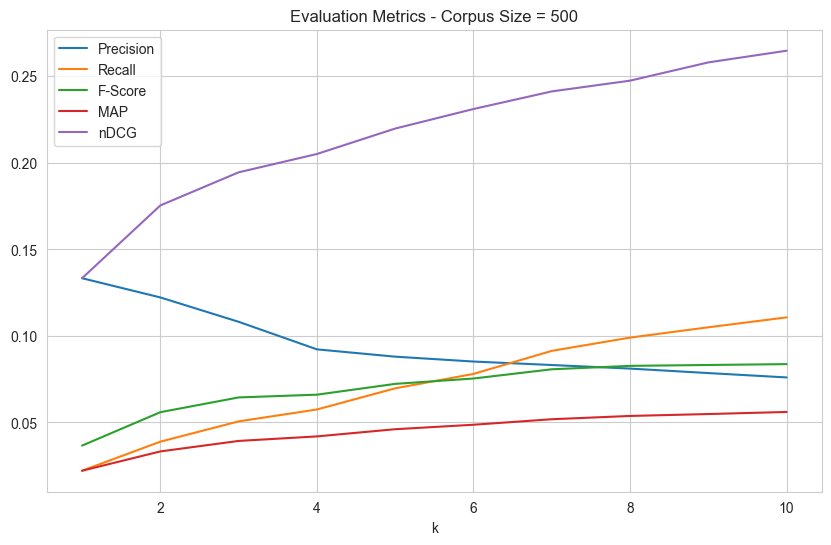

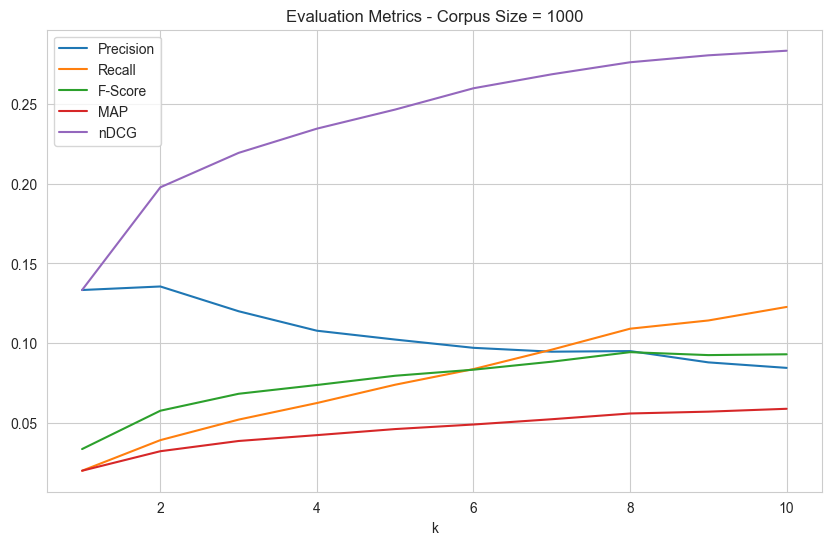

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from evaluation import Evaluation
if not os.path.exists("esa"):

    os.makedirs("esa")

for corpus_size in corpus_sizes:
    ir = ESAInformationRetrieval(corpus_size=corpus_size)
    ir.build_vectors()

    queries_json = json.load(open("cranfield/cran_queries.json", 'r'))
    qrels = json.load(open("cranfield/cran_qrels.json", 'r'))

    query_ids, queries = [item["query number"] for item in queries_json], [item["query"] for item in queries_json]


    evaluator = Evaluation()

    doc_IDs_ordered = [ir.rank(query) for query in queries]

    precisions, recalls, fscores, MAPs, nDCGs = [], [], [], [], []

    for k in range(1, 11):
        precision = evaluator.meanPrecision(doc_IDs_ordered, query_ids, qrels, k)
        precisions.append(precision)
        recall = evaluator.meanRecall(doc_IDs_ordered, query_ids, qrels, k)
        recalls.append(recall)
        fscore = evaluator.meanFscore(doc_IDs_ordered, query_ids, qrels, k)
        fscores.append(fscore)
        #print("Precision, Recall and F-score @ " + str(k) + " : " + str(precision) + ", " + str(recall) + ", " + str(fscore))
        MAP = evaluator.meanAveragePrecision(doc_IDs_ordered, query_ids, qrels, k)
        MAPs.append(MAP)
        nDCG = evaluator.meanNDCG(doc_IDs_ordered, query_ids, qrels, k)
        nDCGs.append(nDCG)
        #print("MAP, nDCG @ " + str(k) + " : " + str(MAP) + ", " + str(nDCG))

    # Plot the metrics and save plot
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    plt.plot(range(1, 11), precisions, label="Precision")
    plt.plot(range(1, 11), recalls, label="Recall")
    plt.plot(range(1, 11), fscores, label="F-Score")
    plt.plot(range(1, 11), MAPs, label="MAP")
    plt.plot(range(1, 11), nDCGs, label="nDCG")
    plt.legend()
    plt.title(f"Evaluation Metrics - Corpus Size = {corpus_size}")
    plt.xlabel("k")
    plt.savefig(f"esa/eval_plot_{corpus_size}.png")
    plt.show()


In [2]:
!git clone https://github.com/petrichor247/ESA-for-IR.git

Cloning into 'ESA-for-IR'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 175 (delta 66), reused 140 (delta 37), pack-reused 0 (from 0)
Receiving objects: 100% (175/175), 18.34 MiB | 20.39 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [9]:
!pip install nltk
import nltk

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


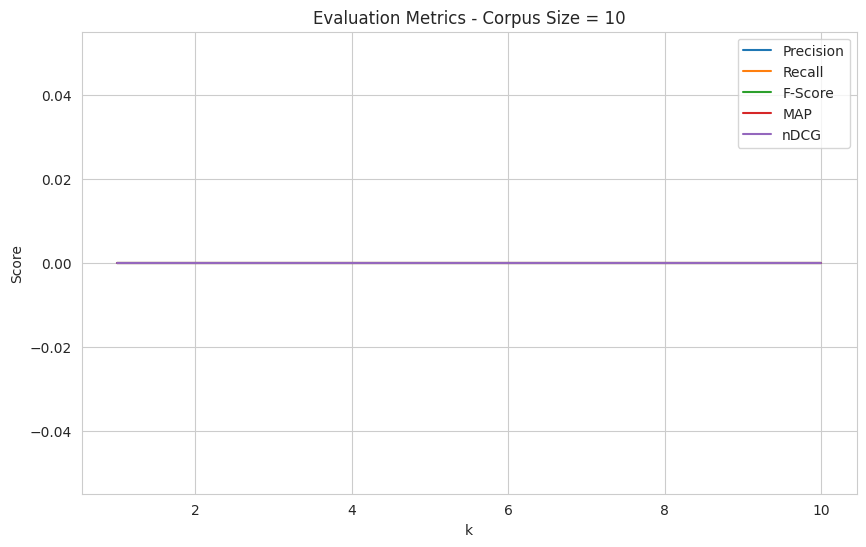

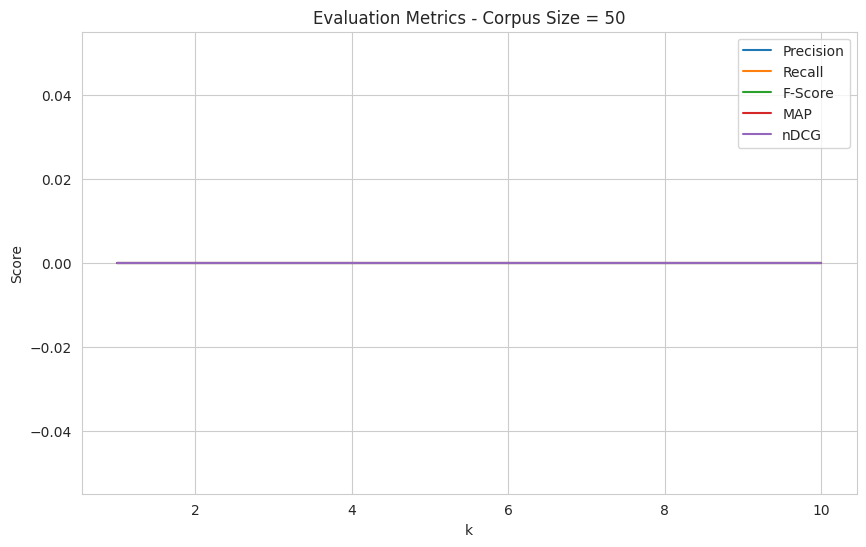

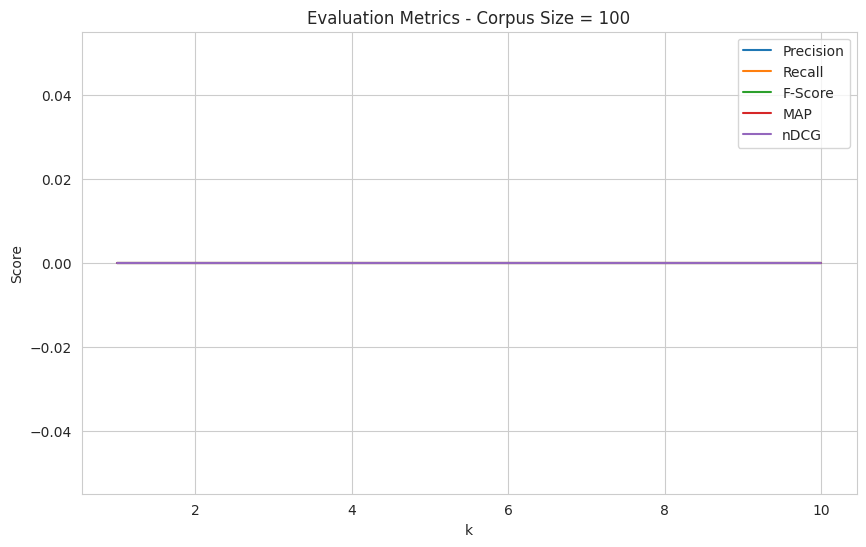

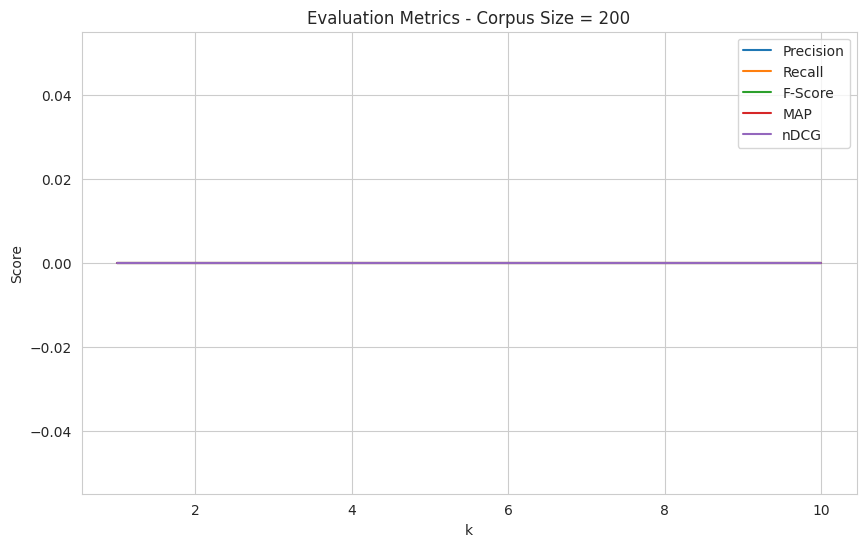

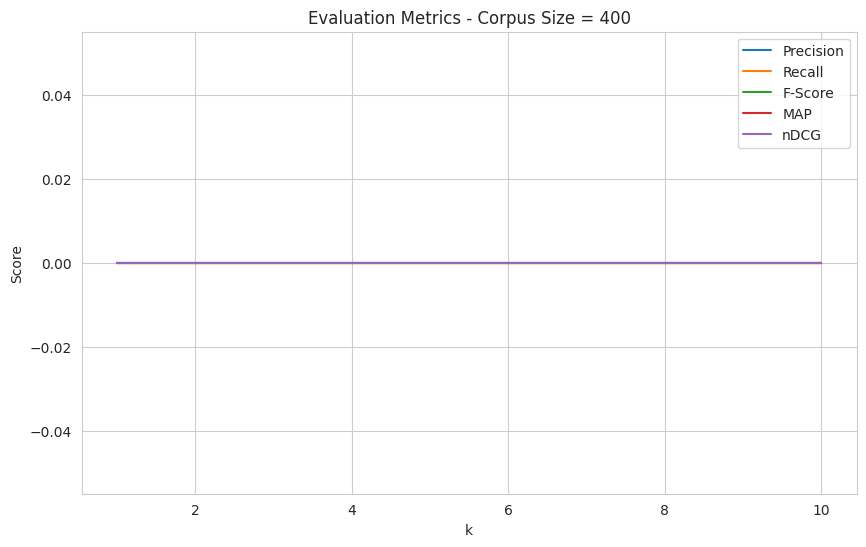

In [12]:
import json
import numpy as np
import nltk
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

def load_and_preprocess_corpus(corpus_file, corpus_size):
    with open(corpus_file, 'r') as file:
        raw_corpus = json.load(file)
    # Select the first corpus_size documents
    limited_items = raw_corpus[:corpus_size]
    # Create a dictionary with 'id' as keys and preprocessed 'body' as values
    processed_corpus = {doc['id']: preprocess(doc['body']) for doc in limited_items}
    return processed_corpus

def build_inverted_index(corpus):
    vectorizer = TfidfVectorizer()
    docs = list(corpus.values())
    tfidf_matrix = vectorizer.fit_transform(docs).T
    vocab = vectorizer.get_feature_names_out()
    inverted_index = {word: tfidf_matrix[i].toarray().flatten() for i, word in enumerate(vocab)}
    return inverted_index, len(docs), vectorizer

def compute_esa_vector(text, inverted_index, vectorizer, n_concepts):
    processed_text = preprocess(text)
    tfidf = vectorizer.transform([processed_text])
    feature_names = vectorizer.get_feature_names_out()
    weights = tfidf.toarray().flatten()
    esa_vector = np.zeros(n_concepts)
    for word, weight in zip(feature_names, weights):
        if word in inverted_index:
            esa_vector += weight * inverted_index[word]
    return esa_vector

class ESAInformationRetrieval:
    def __init__(self, corpus_size=100):
        self.corpus_size = corpus_size
        self.inverted_index = None
        self.vectorizer = None
        self.n_concepts = None
        self.doc_ids = None
        self.doc_vectors = None

    def build_vectors(self):
        corpus = load_and_preprocess_corpus("ESA-for-IR/cranfield/cran_docs.json", self.corpus_size)
        self.doc_ids = list(corpus.keys())
        self.inverted_index, self.n_concepts, self.vectorizer = build_inverted_index(corpus)
        self.doc_vectors = []
        for text in corpus.values():
            vec = compute_esa_vector(text, self.inverted_index, self.vectorizer, self.n_concepts)
            self.doc_vectors.append(vec)
        self.doc_vectors = np.vstack(self.doc_vectors)

    def rank(self, query):
        query_vec = compute_esa_vector(query, self.inverted_index, self.vectorizer, self.n_concepts).reshape(1, -1)
        scores = cosine_similarity(query_vec, self.doc_vectors).flatten()
        ranked_indices = scores.argsort()[::-1]
        return [self.doc_ids[i] for i in ranked_indices], scores[ranked_indices]

if __name__ == "__main__":
    corpus_sizes = [10, 50, 100, 200, 400]

    if not os.path.exists("esa"):
        os.makedirs("esa")

    for corpus_size in corpus_sizes:
        ir = ESAInformationRetrieval(corpus_size=corpus_size)
        ir.build_vectors()

        queries_json = json.load(open("ESA-for-IR/cranfield/cran_queries.json", 'r'))
        qrels = json.load(open("ESA-for-IR/cranfield/cran_qrels.json", 'r'))

        query_ids = [item["query number"] for item in queries_json]
        queries = [item["query"] for item in queries_json]

        # Build qrel_dict with string document IDs
        qrel_dict = {}
        for q in qrels:
            qrel_dict.setdefault(int(q["query_num"]), []).append(str(q["id"]))

        doc_IDs_ordered = [ir.rank(query)[0] for query in queries]

        precisions, recalls, fscores, MAPs, nDCGs = [], [], [], [], []

        for k in range(1, 11):
            relevant_docs = [qrel_dict.get(qid, []) for qid in query_ids]
            retrieved_docs_at_k = [doc_ids[:k] for doc_ids in doc_IDs_ordered]

            p_list, r_list, f_list, ap_list, ndcg_list = [], [], [], [], []

            for retrieved, relevant in zip(retrieved_docs_at_k, relevant_docs):
                rel_set = set(relevant)
                retrieved_set = set(retrieved)
                true_positives = len(rel_set & retrieved_set)

                precision = true_positives / len(retrieved) if retrieved else 0
                recall = true_positives / len(rel_set) if rel_set else 0
                f = (2 * precision * recall) / (precision + recall) if precision + recall else 0

                ap = 0.0
                hits = 0
                for i, doc_id in enumerate(retrieved):
                    if doc_id in rel_set:
                        hits += 1
                        ap += hits / (i + 1)
                ap /= len(rel_set) if rel_set else 1

                # Use string comparison in dcg calculation
                dcg = sum([1 / np.log2(i + 2) if retrieved[i] in rel_set else 0 for i in range(len(retrieved))])
                idcg = sum([1 / np.log2(i + 2) for i in range(min(len(rel_set), k))])
                ndcg = dcg / idcg if idcg > 0 else 0

                p_list.append(precision)
                r_list.append(recall)
                f_list.append(f)
                ap_list.append(ap)
                ndcg_list.append(ndcg)

            precisions.append(np.mean(p_list))
            recalls.append(np.mean(r_list))
            fscores.append(np.mean(f_list))
            MAPs.append(np.mean(ap_list))
            nDCGs.append(np.mean(ndcg_list))

        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")
        plt.plot(range(1, 11), precisions, label="Precision")
        plt.plot(range(1, 11), recalls, label="Recall")
        plt.plot(range(1, 11), fscores, label="F-Score")
        plt.plot(range(1, 11), MAPs, label="MAP")
        plt.plot(range(1, 11), nDCGs, label="nDCG")
        plt.legend()
        plt.title(f"Evaluation Metrics - Corpus Size = {corpus_size}")
        plt.xlabel("k")
        plt.ylabel("Score")
        plt.savefig(f"esa/eval_plot_{corpus_size}.png")
        plt.show()

In [13]:
import json
import numpy as np
import nltk
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required NLTK resources (if not already downloaded)
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

def load_and_preprocess_corpus(corpus_file, corpus_size):
    with open(corpus_file, 'r') as file:
        raw_corpus = json.load(file)
    # Select the first corpus_size documents
    limited_items = raw_corpus[:corpus_size]
    # Create a dictionary with 'id' as keys (converted to str for consistency) and preprocessed 'body' as values
    processed_corpus = {str(doc['id']): preprocess(doc['body']) for doc in limited_items}
    return processed_corpus

def build_inverted_index(corpus):
    vectorizer = TfidfVectorizer()
    docs = list(corpus.values())
    tfidf_matrix = vectorizer.fit_transform(docs).T
    vocab = vectorizer.get_feature_names_out()
    inverted_index = {word: tfidf_matrix[i].toarray().flatten() for i, word in enumerate(vocab)}
    return inverted_index, len(docs), vectorizer

def compute_esa_vector(text, inverted_index, vectorizer, n_concepts, debug=False):
    processed_text = preprocess(text)
    tfidf = vectorizer.transform([processed_text])
    feature_names = vectorizer.get_feature_names_out()
    weights = tfidf.toarray().flatten()
    if debug:
        print("----------")
        print("Original text:", text)
        print("Processed text:", processed_text)
        print("TF-IDF Feature Names:", feature_names)
        print("TF-IDF Weights:", weights)
    esa_vector = np.zeros(n_concepts)
    for word, weight in zip(feature_names, weights):
        if word in inverted_index:
            esa_vector += weight * inverted_index[word]
    if debug:
        print("Computed ESA vector:", esa_vector)
        print("----------")
    return esa_vector

class ESAInformationRetrieval:
    def __init__(self, corpus_size=100, debug=False):
        self.corpus_size = corpus_size
        self.inverted_index = None
        self.vectorizer = None
        self.n_concepts = None
        self.doc_ids = None
        self.doc_vectors = None
        self.debug = debug

    def build_vectors(self):
        corpus = load_and_preprocess_corpus("ESA-for-IR/cranfield/cran_docs.json", self.corpus_size)
        print("Loaded Corpus Document IDs:", list(corpus.keys()))
        # Optionally, print a few preprocessed documents for inspection
        for doc_id, text in list(corpus.items())[:3]:
            print(f"Doc ID: {doc_id}, Preprocessed Text (sample): {text[:100]}...")

        self.doc_ids = list(corpus.keys())
        self.inverted_index, self.n_concepts, self.vectorizer = build_inverted_index(corpus)
        if self.debug:
            print("Vocabulary:", self.vectorizer.get_feature_names_out())
            print("Number of concepts (documents):", self.n_concepts)
        self.doc_vectors = []
        for text in corpus.values():
            vec = compute_esa_vector(text, self.inverted_index, self.vectorizer, self.n_concepts, debug=self.debug)
            self.doc_vectors.append(vec)
        self.doc_vectors = np.vstack(self.doc_vectors)
        if self.debug:
            print("Shape of document vectors matrix:", self.doc_vectors.shape)

    def rank(self, query):
        query_vec = compute_esa_vector(query, self.inverted_index, self.vectorizer, self.n_concepts, debug=self.debug).reshape(1, -1)
        scores = cosine_similarity(query_vec, self.doc_vectors).flatten()
        ranked_indices = scores.argsort()[::-1]
        return [self.doc_ids[i] for i in ranked_indices], scores[ranked_indices]

def debug_retrieval():
    # Increase the corpus_size if needed to capture relevant documents from your qrels.
    corpus_size = 100
    ir = ESAInformationRetrieval(corpus_size=corpus_size, debug=True)
    ir.build_vectors()

    # Load queries and qrels
    queries_json = json.load(open("ESA-for-IR/cranfield/cran_queries.json", 'r'))
    qrels = json.load(open("ESA-for-IR/cranfield/cran_qrels.json", 'r'))

    # Convert query numbers to integers for consistency.
    query_ids = [int(item["query number"]) for item in queries_json]
    queries = [item["query"] for item in queries_json]

    # Build qrel_dict with document IDs as strings.
    qrel_dict = {}
    for q in qrels:
        key = int(q["query_num"])
        qrel_dict.setdefault(key, []).append(str(q["id"]))
    print("Qrels dictionary:", qrel_dict)

    # Debug each query individually.
    for qid, query in zip(query_ids, queries):
        print("\n====================================")
        print(f"Query number: {qid}")
        print("Original Query:", query)
        print("Processed Query:", preprocess(query))
        ranked_doc_ids, scores = ir.rank(query)
        print("Ranked Document IDs:", ranked_doc_ids)
        print("Similarity Scores:", scores)
        relevant_docs = qrel_dict.get(qid, [])
        print("Relevant Docs from Qrels:", relevant_docs)
        true_matches = set(ranked_doc_ids) & set(relevant_docs)
        print("Matched Document IDs:", true_matches)
        if not true_matches:
            print("No relevant documents found in the ranked list. There might be an ID mismatch or the corpus subset doesn't include the relevant docs.")

if __name__ == "__main__":
    debug_retrieval()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Streaming output truncated to the last 5000 lines.
 0.00938363 0.0289703  0.08540413 0.00300804 0.         0.
 0.         0.027612   0.00515693 0.00627399 0.02592722 0.03285461
 0.0554564  0.01617491 0.         0.         0.         0.
 0.         0.         0.08329499 0.         0.         0.03398903
 0.03632609 0.0152083  0.01337511 0.02160177 0.01782233 0.
 0.03618447 0.         0.00736051 0.06224661 0.03429337 0.00560234
 0.08456249 0.1055845  0.05165343 0.        ]
----------
Ranked Document IDs: ['34', '97', '98', '17', '73', '94', '49', '2', '54', '33', '81', '55', '23', '4', '63', '62', '3', '50', '28', '59', '16', '19', '84', '37', '25', '9', '89', '72', '74', '27', '35', '22', '24', '88', '99', '45', '11', '87', '61', '29', '56', '44', '21', '39', '26', '41', '85', '91', '71', '48', '53', '93', '68', '58', '76', '36', '6', '14', '18', '57', '95', '38', '70', '43', '60', '47', '79', '86', '20', '80', '13', '69', '15', '52', '90', '96', '40', '7', '82', '30', '51', '78', '64', 

In [14]:
import json
import numpy as np
import nltk
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Ensure required NLTK resources are downloaded
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

def load_and_preprocess_corpus(corpus_file, corpus_size):
    with open(corpus_file, 'r') as file:
        raw_corpus = json.load(file)
    # Select only the first corpus_size documents and convert document IDs to strings for consistency.
    limited_items = raw_corpus[:corpus_size]
    processed_corpus = {str(doc['id']): preprocess(doc['body']) for doc in limited_items}
    return processed_corpus

def build_inverted_index(corpus):
    vectorizer = TfidfVectorizer()
    docs = list(corpus.values())
    tfidf_matrix = vectorizer.fit_transform(docs).T
    vocab = vectorizer.get_feature_names_out()
    inverted_index = {word: tfidf_matrix[i].toarray().flatten() for i, word in enumerate(vocab)}
    return inverted_index, len(docs), vectorizer

def compute_esa_vector(text, inverted_index, vectorizer, n_concepts, debug=False):
    processed_text = preprocess(text)
    tfidf = vectorizer.transform([processed_text])
    feature_names = vectorizer.get_feature_names_out()
    weights = tfidf.toarray().flatten()
    if debug:
        print("----------")
        print("Original text:", text)
        print("Processed text:", processed_text)
        print("TF-IDF Feature Names:", feature_names)
        print("TF-IDF Weights:", weights)
    esa_vector = np.zeros(n_concepts)
    for word, weight in zip(feature_names, weights):
        if word in inverted_index:
            esa_vector += weight * inverted_index[word]
    if debug:
        print("Computed ESA vector:", esa_vector)
        print("----------")
    return esa_vector

class ESAInformationRetrieval:
    def __init__(self, corpus_size=100, debug=False):
        self.corpus_size = corpus_size
        self.inverted_index = None
        self.vectorizer = None
        self.n_concepts = None
        self.doc_ids = None
        self.doc_vectors = None
        self.debug = debug

    def build_vectors(self):
        corpus = load_and_preprocess_corpus("ESA-for-IR/cranfield/cran_docs.json", self.corpus_size)
        print("Loaded Corpus Document IDs:", list(corpus.keys()))
        # Show a preview (first 3 documents) of preprocessed texts for verification.
        for doc_id, text in list(corpus.items())[:3]:
            print(f"Doc ID: {doc_id}, Preprocessed Text (sample): {text[:100]}...")
        self.doc_ids = list(corpus.keys())
        self.inverted_index, self.n_concepts, self.vectorizer = build_inverted_index(corpus)
        if self.debug:
            print("Vocabulary:", self.vectorizer.get_feature_names_out())
            print("Number of concepts (documents):", self.n_concepts)
        self.doc_vectors = []
        for text in corpus.values():
            vec = compute_esa_vector(text, self.inverted_index, self.vectorizer, self.n_concepts, debug=self.debug)
            self.doc_vectors.append(vec)
        self.doc_vectors = np.vstack(self.doc_vectors)
        if self.debug:
            print("Shape of document vectors matrix:", self.doc_vectors.shape)

    def rank(self, query):
        query_vec = compute_esa_vector(query, self.inverted_index, self.vectorizer, self.n_concepts, debug=self.debug).reshape(1, -1)
        scores = cosine_similarity(query_vec, self.doc_vectors).flatten()
        ranked_indices = scores.argsort()[::-1]
        return [self.doc_ids[i] for i in ranked_indices], scores[ranked_indices]

def debug_evaluation_metrics(ir, query_ids, queries, qrel_dict):
    # For each query, print debugging information including retrieval results and evaluation metrics at various k.
    for qid, query in zip(query_ids, queries):
        print("\n====================================")
        print(f"Query number: {qid}")
        print("Original Query:", query)
        print("Processed Query:", preprocess(query))

        ranked_doc_ids, scores = ir.rank(query)
        print("Ranked Document IDs:", ranked_doc_ids)
        print("Similarity Scores:", scores)

        relevant_docs = set(qrel_dict.get(qid, []))
        print("Relevant Docs from Qrels:", relevant_docs)

        # Identify at which rank each relevant document is found.
        for doc in relevant_docs:
            if doc in ranked_doc_ids:
                print(f"Relevant Document {doc} found at rank: {ranked_doc_ids.index(doc) + 1}")
            else:
                print(f"Relevant Document {doc} not found in ranking.")

        # Debug evaluation metrics at increasing cutoff values (e.g., k = 1 to 20).
        for k in range(1, 21):
            retrieved = ranked_doc_ids[:k]
            retrieved_set = set(retrieved)
            true_positives = len(retrieved_set & relevant_docs)
            precision = true_positives / k
            recall = true_positives / len(relevant_docs) if relevant_docs else 0
            print(f"At k={k:2d}: Retrieved = {retrieved}, TP = {true_positives}, Precision = {precision:.3f}, Recall = {recall:.3f}")

def debug_all():
    # Adjust corpus size as needed to ensure relevant documents from qrels are covered in your corpus.
    corpus_size = 100  # You might increase this if your relevant document IDs are outside the current subset.
    ir = ESAInformationRetrieval(corpus_size=corpus_size, debug=True)
    ir.build_vectors()

    # Load queries and qrels data.
    queries_json = json.load(open("ESA-for-IR/cranfield/cran_queries.json", 'r'))
    qrels = json.load(open("ESA-for-IR/cranfield/cran_qrels.json", 'r'))

    # Convert query numbers to integers for consistency.
    query_ids = [int(item["query number"]) for item in queries_json]
    queries = [item["query"] for item in queries_json]

    # Build qrel_dict with document IDs as strings.
    qrel_dict = {}
    for q in qrels:
        key = int(q["query_num"])   # Ensure both keys use the same type (integer)
        qrel_dict.setdefault(key, []).append(str(q["id"]))
    print("Qrels Dictionary:", qrel_dict)

    # Call the debugging evaluation function.
    debug_evaluation_metrics(ir, query_ids, queries, qrel_dict)

if __name__ == "__main__":
    debug_all()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Streaming output truncated to the last 5000 lines.
Query number: 160
Original Query: compressive circumferential stresses in a torispherical shell reveal the possibility of buckling under internal pressure . has anyone investigated for which ranges of shell parameters these stresses are sufficiently large to cause elastic buckling .
Processed Query: compressive circumferential stress torispherical shell reveal possibility buckling internal pressure anyone investigated range shell parameter stress sufficiently large cause elastic buckling
----------
Original text: compressive circumferential stresses in a torispherical shell reveal the possibility of buckling under internal pressure . has anyone investigated for which ranges of shell parameters these stresses are sufficiently large to cause elastic buckling .
Processed text: compressive circumferential stress torispherical shell reveal possibility buckling internal pressure anyone investigated range shell parameter stress sufficiently l

In [16]:
!git config --global user.email "sidharthan.sc@gmail.com"
!git config --global user.name "Sidharthan S C"

In [17]:
!cd /content/ESA-for-IR
!git add ESA.ipynb
!git commit -m "Updated ESA.ipynb"

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [18]:
%cd ESA-for-IR
!cp /content/ESA-for-IR/ESA.ipynb


/content/ESA-for-IR
cp: missing destination file operand after '/content/ESA-for-IR/ESA.ipynb'
Try 'cp --help' for more information.


GLOVE

In [23]:
import json
import random
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Preprocessing function
def preprocess(text):
    tokens = word_tokenize(text.lower())
    # Keep only alphabetic tokens and remove stopwords.
    stop_words = set(nltk.corpus.stopwords.words("english"))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Optional: you could add lemmatization here if desired.
    return tokens

# -----------------------------------------------------------------------------
# Data Loading: Cranfield Documents, Queries, and Qrels
# -----------------------------------------------------------------------------
def load_cran_docs(corpus_file="ESA-for-IR/cranfield/cran_docs.json", corpus_size=None):
    with open(corpus_file, 'r') as f:
        docs = json.load(f)
    if corpus_size:
        docs = docs[:corpus_size]
    corpus = {}
    for doc in docs:
        # Convert doc ID to string
        corpus[str(doc['id'])] = preprocess(doc['body'])
    return corpus

def load_cran_queries(query_file="ESA-for-IR/cranfield/cran_queries.json"):
    with open(query_file, 'r') as f:
        queries_json = json.load(f)
    queries = {}
    for item in queries_json:
        queries[int(item["query number"])] = item["query"]
    return queries

def load_cran_qrels(qrel_file="ESA-for-IR/cranfield/cran_qrels.json"):
    with open(qrel_file, 'r') as f:
        qrels_json = json.load(f)
    qrel_dict = {}
    for entry in qrels_json:
        qnum = int(entry["query_num"])
        doc_id = entry["id"]  # Already a string in the qrels.
        qrel_dict.setdefault(qnum, set()).add(doc_id)
    return qrel_dict

# Load data
corpus = load_cran_docs(corpus_file="ESA-for-IR/cranfield/cran_docs.json", corpus_size=None)
queries = load_cran_queries("ESA-for-IR/cranfield/cran_queries.json")
qrels = load_cran_qrels("ESA-for-IR/cranfield/cran_qrels.json")

# -----------------------------------------------------------------------------
# Build Vocabulary from both Documents and Queries
# -----------------------------------------------------------------------------
def build_vocab(corpus, queries):
    word2idx = {"<PAD>": 0}
    idx = 1
    for tokens in corpus.values():
        for token in tokens:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1
    for query in queries.values():
        for token in preprocess(query):
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1
    return word2idx

word2idx = build_vocab(corpus, queries)
vocab_size = len(word2idx)
embedding_dim = 200  # Use 200 dimensions

# -----------------------------------------------------------------------------
# Load Pre-Trained GloVe and Build Embedding Matrix
# -----------------------------------------------------------------------------
def load_glove_embeddings(glove_path="glove.6B.200d.txt", word2idx=word2idx, embed_dim=embedding_dim):
    embeddings = np.random.normal(0, 0.1, (len(word2idx), embed_dim))
    embeddings[word2idx["<PAD>"]] = np.zeros(embed_dim)
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            if word in word2idx:
                vec = np.array(parts[1:], dtype=np.float32)
                embeddings[word2idx[word]] = vec
    return embeddings

glove_matrix = load_glove_embeddings()

# -----------------------------------------------------------------------------
# Create Training Samples (Triplets: Query, Positive Doc, Negative Doc)
# -----------------------------------------------------------------------------
def create_training_samples(corpus, queries, qrels):
    """
    For each query, form training tuples (query_text, pos_doc_id, neg_doc_id).
    Only consider positive documents that exist in the corpus.
    """
    samples = []
    all_doc_ids = list(corpus.keys())
    for qnum, query_text in queries.items():
        if qnum not in qrels:
            continue
        pos_doc_ids = list(qrels[qnum].intersection(set(corpus.keys())))
        if not pos_doc_ids:
            continue
        for pos_id in pos_doc_ids:
            neg_candidates = list(set(all_doc_ids) - qrels[qnum])
            if not neg_candidates:
                continue
            neg_id = random.choice(neg_candidates)
            samples.append((query_text, pos_id, neg_id))
    return samples

training_samples = create_training_samples(corpus, queries, qrels)
print(f"Created {len(training_samples)} training samples.")

# -----------------------------------------------------------------------------
# Utility: Convert Text into Indices (Padding to max_len)
# -----------------------------------------------------------------------------
def text_to_indices(text, word2idx, max_len=100):
    tokens = preprocess(text)
    indices = [word2idx.get(token, 0) for token in tokens]
    if len(indices) < max_len:
        indices += [0] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return indices

def doc_tokens_to_indices(tokens, word2idx, max_len=100):
    indices = [word2idx.get(token, 0) for token in tokens]
    if len(indices) < max_len:
        indices += [0] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return indices

# -----------------------------------------------------------------------------
# PyTorch Dataset for Cranfield Fine-Tuning
# -----------------------------------------------------------------------------
class CRANDataset(Dataset):
    def __init__(self, samples, corpus, word2idx, max_len=100):
        self.samples = samples
        self.corpus = corpus
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        query_text, pos_doc_id, neg_doc_id = self.samples[idx]
        query_indices = text_to_indices(query_text, self.word2idx, self.max_len)
        pos_indices = doc_tokens_to_indices(self.corpus[pos_doc_id], self.word2idx, self.max_len)
        neg_indices = doc_tokens_to_indices(self.corpus[neg_doc_id], self.word2idx, self.max_len)
        return (torch.tensor(query_indices, dtype=torch.long),
                torch.tensor(pos_indices, dtype=torch.long),
                torch.tensor(neg_indices, dtype=torch.long))

dataset = CRANDataset(training_samples, corpus, word2idx, max_len=100)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# -----------------------------------------------------------------------------
# Define the Ranking Model (with trainable Embedding Layer for Fine Tuning)
# -----------------------------------------------------------------------------
class RankingModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, glove_matrix):
        super(RankingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # Initialize with pretrained GloVe embeddings; fine tuning enabled.
        self.embedding.weight = nn.Parameter(torch.tensor(glove_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = True
        self.fc = nn.Linear(embed_dim, embed_dim)  # Optional transformation

    def forward(self, x):
        # x shape: [batch_size, seq_len]
        emb = self.embedding(x)         # [batch_size, seq_len, embed_dim]
        emb = emb.mean(dim=1)           # Average pooling -> [batch_size, embed_dim]
        emb = torch.tanh(self.fc(emb))  # Optionally transform representation
        return emb

model = RankingModel(vocab_size, embedding_dim, glove_matrix)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# -----------------------------------------------------------------------------
# Define Ranking Loss (Pairwise Hinge Loss)
# -----------------------------------------------------------------------------
cos_sim = nn.CosineSimilarity(dim=1)
def ranking_loss(query_vec, pos_vec, neg_vec, margin=0.1):
    pos_sim = cos_sim(query_vec, pos_vec)
    neg_sim = cos_sim(query_vec, neg_vec)
    loss = torch.clamp(margin - pos_sim + neg_sim, min=0.0)
    return loss.mean()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# -----------------------------------------------------------------------------
# Fine Tuning Training Loop
# -----------------------------------------------------------------------------
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch in dataloader:
        query_batch, pos_batch, neg_batch = [b.to(device) for b in batch]
        optimizer.zero_grad()
        query_vec = model(query_batch)
        pos_vec = model(pos_batch)
        neg_vec = model(neg_batch)
        loss = ranking_loss(query_vec, pos_vec, neg_vec)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("Fine tuning complete. The embedding weights have been updated.")

Created 1837 training samples.
Epoch 1/10, Loss: 0.0691
Epoch 2/10, Loss: 0.0228
Epoch 3/10, Loss: 0.0078
Epoch 4/10, Loss: 0.0034
Epoch 5/10, Loss: 0.0014
Epoch 6/10, Loss: 0.0003
Epoch 7/10, Loss: 0.0002
Epoch 8/10, Loss: 0.0003
Epoch 9/10, Loss: 0.0003
Epoch 10/10, Loss: 0.0001
Fine tuning complete. The embedding weights have been updated.


In [7]:
!pip install nltk

In [18]:
import json
import numpy as np
import nltk
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required NLTK resources.
nltk.download("punkt_tab")  # if you intend to use the "punkt" tokenizer, consider using "punkt"
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    """
    Tokenize, lowercase, remove non-alphabetic tokens, remove stopwords, and lemmatize.
    """
    tokens = word_tokenize(text.lower())
    # Keep only alphabetic tokens and remove stopwords.
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens  # Return token list

def load_and_preprocess_corpus(corpus_file, corpus_size):
    """
    Load the JSON corpus file, limit to corpus_size, and preprocess document bodies.
    Document IDs are converted to strings to ensure type consistency with qrels.
    """
    if not os.path.exists(corpus_file):
        raise FileNotFoundError(f"Corpus file not found: {corpus_file}")

    with open(corpus_file, 'r') as file:
        raw_corpus = json.load(file)

    limited_items = raw_corpus[:corpus_size]
    if not limited_items:
        raise ValueError("No documents loaded. Check your corpus file or corpus size parameter.")

    processed_corpus = {str(doc['id']): preprocess(doc['body']) for doc in limited_items}
    return processed_corpus


def load_glove_embeddings(glove_path="glove.6B.200d.txt"):
    """
    Load GloVe embeddings from a file into a dictionary.
    """
    if not os.path.exists(glove_path):
        raise FileNotFoundError(f"GloVe file not found: {glove_path}")

    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            word = parts[0]
            vec = np.array(parts[1:], dtype=np.float32)
            embeddings[word] = vec
    if not embeddings:
        raise ValueError("No embeddings loaded. Check your GloVe file.")
    return embeddings

def compute_glove_vector(tokens, glove, dim=200):
    """
    Compute a document or query vector by averaging the GloVe vectors for tokens.
    If none of the tokens are in the GloVe vocabulary, return a zero vector.
    """
    vecs = [glove[word] for word in tokens if word in glove]
    if vecs:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(dim)

class GloVeInformationRetrieval:
    def __init__(self, corpus_size=100, glove_path="glove.6B.200d.txt",
                 corpus_file="ESA-for-IR/cranfield/cran_docs.json"):
        """
        Initialize the IR system with a corpus size, path to the GloVe file,
        and path to the corpus file.
        """
        self.corpus_size = corpus_size
        self.glove = load_glove_embeddings(glove_path)
        self.embedding_dim = len(next(iter(self.glove.values())))
        self.doc_vectors = None
        self.doc_ids = None
        self.corpus = None
        self.corpus_file = corpus_file

    def build_vectors(self):
        """
        Load and preprocess the corpus, and compute a vector for each document.
        """
        self.corpus = load_and_preprocess_corpus(self.corpus_file, self.corpus_size)
        self.doc_ids = list(self.corpus.keys())
        vectors = []
        for tokens in self.corpus.values():
            vec = compute_glove_vector(tokens, self.glove, self.embedding_dim)
            vectors.append(vec)
        self.doc_vectors = np.vstack(vectors)
        # Optional: Report if any document vector is all zeros.
        zero_vecs = np.sum(np.linalg.norm(self.doc_vectors, axis=1)==0)
        if zero_vecs > 0:
            print(f"Warning: {zero_vecs} document(s) produced zero vectors.")

    def rank(self, query):
        """
        Process a query, compute its GloVe vector, issue a warning if it results in a zero vector,
        compute cosine similarities with the document vectors, and return ranked document IDs.
        """
        query_tokens = preprocess(query)
        query_vec = compute_glove_vector(query_tokens, self.glove, self.embedding_dim).reshape(1, -1)

        if not np.any(query_vec):
            print("Warning: Query vector is zero. Check if the query contains words in the GloVe vocabulary.")

        scores = cosine_similarity(query_vec, self.doc_vectors).flatten()
        ranked_indices = scores.argsort()[::-1]
        ranked_docIDs = [self.doc_ids[i] for i in ranked_indices]
        return ranked_docIDs, scores[ranked_indices]

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
!unzip glove.6B.200d.txt.zip

Archive:  glove.6B.200d.txt.zip
  inflating: glove.6B.200d.txt       


Evaluating Corpus Sizes:   0%|          | 0/6 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.

Query 114:
Retrieved: ['1', '9', '8', '7', '6', '2']
Relevant : ['919', '916', '920', '921', '895']
⚠️ No true positives.

Query 115:
Retrieved: ['8', '1', '10', '6', '9', '2']
Relevant : ['51', '185', '878', '874', '184']
⚠️ No true positives.

Query 116:
Retrieved: ['7', '9', '5', '1', '6', '4']
Relevant : ['922', '360', '605', '927', '492', '896']
⚠️ No true positives.

Query 117:
Retrieved: ['1', '8', '9', '7', '10', '6']
Relevant : ['360', '605', '896']
⚠️ No true positives.

Query 118:
Retrieved: ['1', '7', '9', '8', '10', '2']
Relevant : ['923', '924', '925', '896']
⚠️ No true positives.

Query 119:
Retrieved: ['10', '2', '4', '3', '5', '6']
Relevant : ['926', '897']
⚠️ No true positives.

Query 120:
Retrieved: ['9', '10', '5', '7', '6', '8']
Relevant : ['829', '887', '890', '885', '886', '888', '889', '1146', '891', '769']
⚠️ No true positives.

Query 121:
Retrieved: ['5', '9', '10', '2', '6', '7']
Relevant : ['885', '886', '1

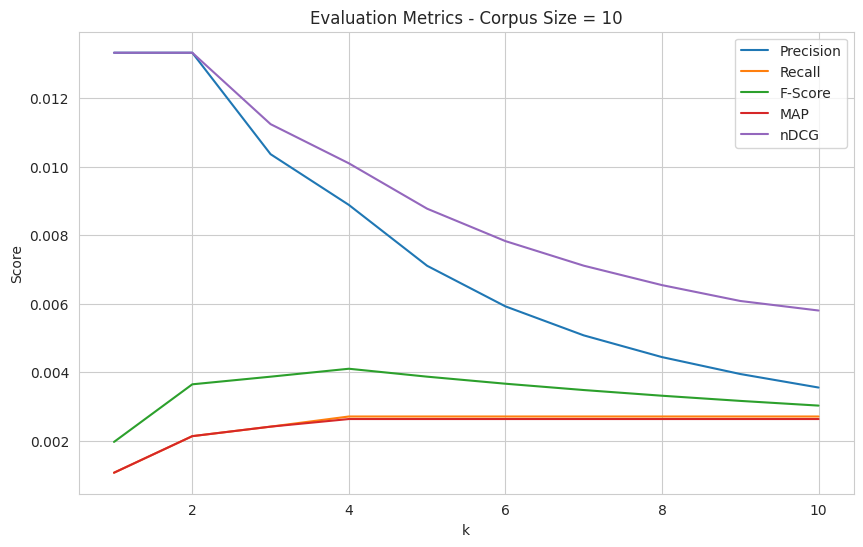

Evaluating Corpus Sizes:  17%|█▋        | 1/6 [00:24<02:00, 24.11s/it]


=== Corpus Size: 50 ===


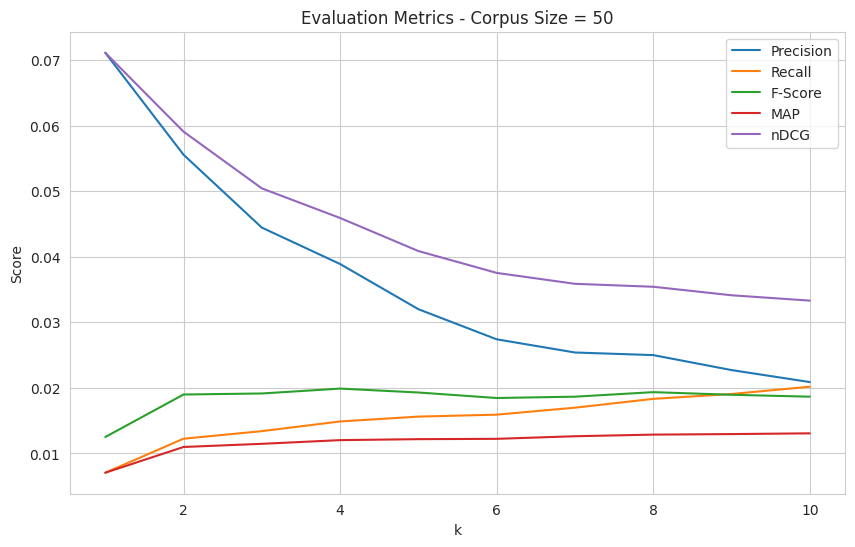

Evaluating Corpus Sizes:  33%|███▎      | 2/6 [00:46<01:32, 23.16s/it]


=== Corpus Size: 100 ===


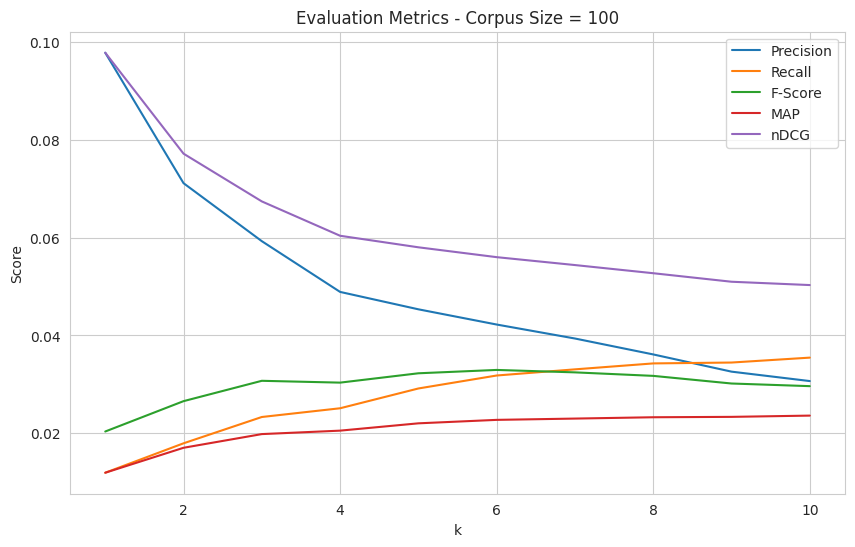

Evaluating Corpus Sizes:  50%|█████     | 3/6 [01:08<01:08, 22.80s/it]


=== Corpus Size: 200 ===


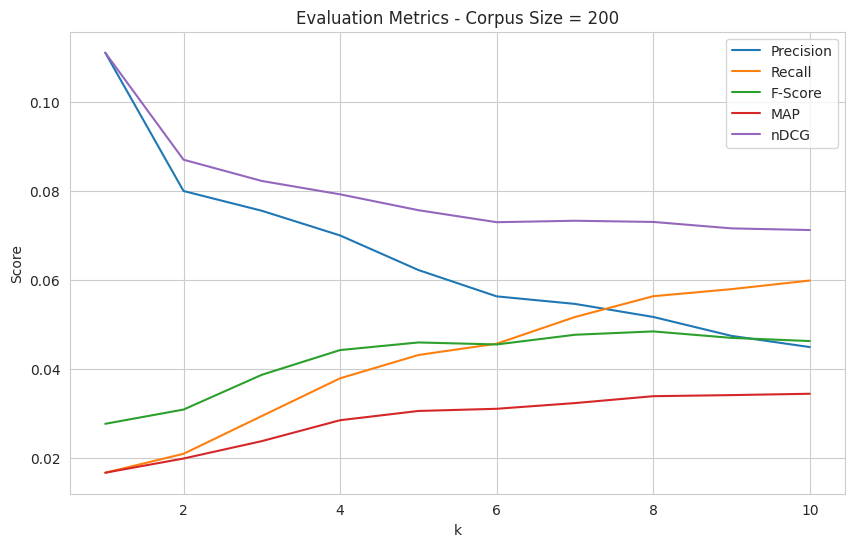

Evaluating Corpus Sizes:  67%|██████▋   | 4/6 [01:30<00:44, 22.42s/it]


=== Corpus Size: 400 ===


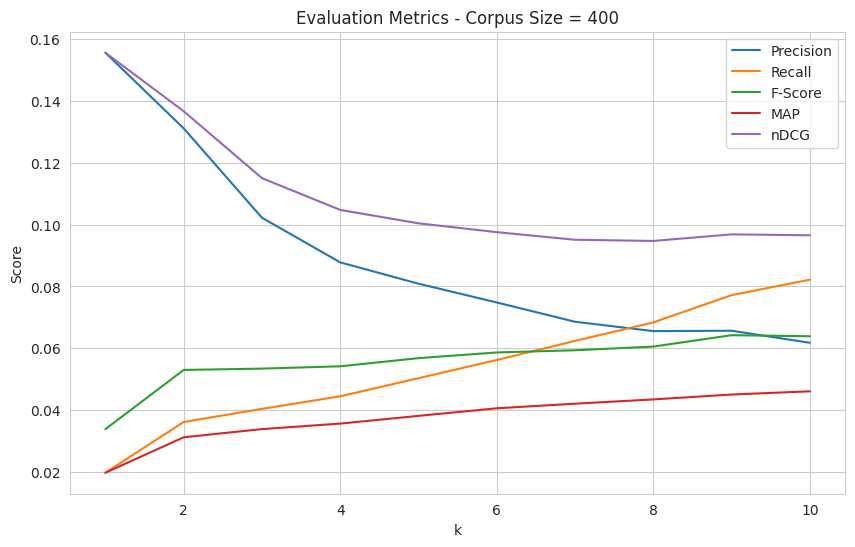

Evaluating Corpus Sizes:  83%|████████▎ | 5/6 [01:54<00:22, 22.77s/it]


=== Corpus Size: 1500 ===


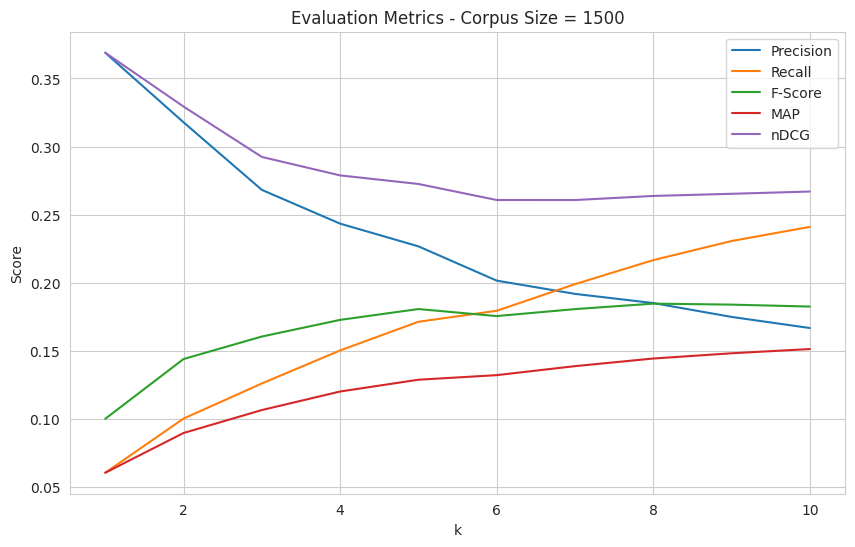

Evaluating Corpus Sizes: 100%|██████████| 6/6 [02:19<00:00, 23.25s/it]


In [20]:
if __name__ == "__main__":
    corpus_sizes = [10, 50, 100, 200, 400, 1500]

    if not os.path.exists("glove"):
        os.makedirs("glove")

    from tqdm import tqdm

    for corpus_size in tqdm(corpus_sizes, desc="Evaluating Corpus Sizes"):
        print(f"\n=== Corpus Size: {corpus_size} ===")

        ir = GloVeInformationRetrieval(corpus_size=corpus_size)
        ir.build_vectors()

        queries_json = json.load(open("ESA-for-IR/cranfield/cran_queries.json", 'r'))
        qrels = json.load(open("ESA-for-IR/cranfield/cran_qrels.json", 'r'))

        query_ids = [item["query number"] for item in queries_json]
        queries = [item["query"] for item in queries_json]

        qrel_dict = {}
        for q in qrels:
            qrel_dict.setdefault(int(q["query_num"]), []).append(str(q["id"]))

        doc_IDs_ordered = [ir.rank(query)[0] for query in queries]

        precisions, recalls, fscores, MAPs, nDCGs = [], [], [], [], []

        for k in range(1, 11):
            relevant_docs = [qrel_dict.get(qid, []) for qid in query_ids]
            retrieved_docs_at_k = [doc_ids[:k] for doc_ids in doc_IDs_ordered]

            p_list, r_list, f_list, ap_list, ndcg_list = [], [], [], [], []

            for i, (retrieved, relevant) in enumerate(zip(retrieved_docs_at_k, relevant_docs)):
                rel_set = set(relevant)
                retrieved_set = set(retrieved)
                true_positives = len(rel_set & retrieved_set)

                # Print detailed debug info
                if true_positives == 0 and corpus_size == 10:
                    print(f"\nQuery {i+1}:")
                    print(f"Retrieved: {retrieved}")
                    print(f"Relevant : {relevant}")
                    print("⚠️ No true positives.")

                precision = true_positives / len(retrieved) if retrieved else 0
                recall = true_positives / len(rel_set) if rel_set else 0
                f = (2 * precision * recall) / (precision + recall) if precision + recall else 0

                ap = 0.0
                hits = 0
                for j, doc_id in enumerate(retrieved):
                    if doc_id in rel_set:
                        hits += 1
                        ap += hits / (j + 1)
                ap /= len(rel_set) if rel_set else 1

                dcg = sum([1 / np.log2(j + 2) if retrieved[j] in rel_set else 0 for j in range(len(retrieved))])
                idcg = sum([1 / np.log2(j + 2) for j in range(min(len(rel_set), k))])
                ndcg = dcg / idcg if idcg > 0 else 0

                p_list.append(precision)
                r_list.append(recall)
                f_list.append(f)
                ap_list.append(ap)
                ndcg_list.append(ndcg)

            precisions.append(np.mean(p_list))
            recalls.append(np.mean(r_list))
            fscores.append(np.mean(f_list))
            MAPs.append(np.mean(ap_list))
            nDCGs.append(np.mean(ndcg_list))

        # Plotting remains unchanged
        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")
        plt.plot(range(1, 11), precisions, label="Precision")
        plt.plot(range(1, 11), recalls, label="Recall")
        plt.plot(range(1, 11), fscores, label="F-Score")
        plt.plot(range(1, 11), MAPs, label="MAP")
        plt.plot(range(1, 11), nDCGs, label="nDCG")
        plt.legend()
        plt.title(f"Evaluation Metrics - Corpus Size = {corpus_size}")
        plt.xlabel("k")
        plt.ylabel("Score")
        plt.savefig(f"esa/eval_plot_{corpus_size}.png")
        plt.show()

In [15]:
# Load and preprocess the corpus
processed_corpus = load_and_preprocess_corpus("ESA-for-IR/cranfield/cran_docs.json", corpus_size)
available_doc_ids = set(processed_corpus.keys())

# Load qrels and build a filtered qrel dictionary.
with open("ESA-for-IR/cranfield/cran_qrels.json", 'r') as file:
    raw_qrels = json.load(file)

qrel_dict = {}
for q in raw_qrels:
    # Use q['id'] directly since we now use strings everywhere.
    if q["id"] in available_doc_ids:
        # Convert query number to integer for internal consistency if needed.
        query_number = int(q["query_num"])
        qrel_dict.setdefault(query_number, []).append(q["id"])

In [17]:
qrel_dict

{1: ['184',
  '29',
  '31',
  '12',
  '51',
  '102',
  '13',
  '14',
  '15',
  '57',
  '378',
  '185',
  '30',
  '37',
  '52',
  '142',
  '195',
  '56',
  '66',
  '95'],
 2: ['12',
  '15',
  '184',
  '51',
  '102',
  '202',
  '14',
  '52',
  '380',
  '285',
  '390',
  '391'],
 3: ['5', '6', '90', '91', '119', '144', '181', '399'],
 4: ['236', '166'],
 6: ['99', '115', '257', '258'],
 7: ['20', '56', '57', '58', '19'],
 8: ['48', '122', '20', '58', '196', '354', '360', '197'],
 9: ['21', '22'],
 10: ['259', '302'],
 11: ['27', '28', '262', '160', '20', '263'],
 12: ['86', '194'],
 13: ['64', '265', '65', '311'],
 14: ['64', '65'],
 16: ['266', '106', '196'],
 17: ['106', '196'],
 18: ['196', '197', '198'],
 19: ['32', '67', '164'],
 20: ['87', '88', '104', '267', '268', '269', '270'],
 21: ['271', '16'],
 22: ['68'],
 23: ['200', '201', '199'],
 24: ['46', '47', '92'],
 25: ['213', '212', '214', '215', '216', '276', '277'],
 26: ['145', '376'],
 27: ['224', '278'],
 28: ['224', '279'],


In [25]:
import json
import numpy as np
import nltk
import os
import torch
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    """
    Tokenize, lowercase, remove non-alphabetic tokens, remove stopwords, and lemmatize.
    """
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

def load_and_preprocess_corpus(corpus_file, corpus_size):
    """
    Load the JSON corpus file, limit to corpus_size, and preprocess document bodies.
    Document IDs are converted to strings.
    """
    if not os.path.exists(corpus_file):
        raise FileNotFoundError(f"Corpus file not found: {corpus_file}")

    with open(corpus_file, 'r') as file:
        raw_corpus = json.load(file)

    limited_items = raw_corpus[:corpus_size]
    if not limited_items:
        raise ValueError("No documents loaded. Check your corpus file or corpus size parameter.")

    processed_corpus = {str(doc['id']): preprocess(doc['body']) for doc in limited_items}
    return processed_corpus

def tokens_to_indices(tokens, word2idx, max_len=100):
    """
    Convert a list of tokens into indices based on word2idx.
    Pads or truncates the sequence to max_len.
    """
    indices = [word2idx.get(token, 0) for token in tokens]
    if len(indices) < max_len:
        indices += [0] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return indices

# -----------------------------------------------------------------------------
# Fine-Tuned IR using the Updated Model
# -----------------------------------------------------------------------------
class FineTunedInformationRetrieval:
    def __init__(self, model, word2idx, corpus_file, corpus_size=1000, max_len=100):
        """
        Initialize with the fine-tuned model, vocabulary mapping, and corpus location.
        """
        self.model = model
        self.word2idx = word2idx
        self.corpus_file = corpus_file
        self.corpus_size = corpus_size
        self.max_len = max_len
        self.corpus = None   # dictionary: docID -> token list
        self.doc_ids = None  # list of document IDs
        self.doc_vectors = None  # numpy array of document representations
        self.build_vectors()

    def build_vectors(self):
        """
        Load and preprocess the corpus, then convert each document to index sequences and
        pass them through the fine-tuned model to create document-level vectors.
        """
        self.corpus = load_and_preprocess_corpus(self.corpus_file, self.corpus_size)
        self.doc_ids = list(self.corpus.keys())
        vectors = []
        self.model.eval()  # set model to evaluation mode
        with torch.no_grad():
            for tokens in self.corpus.values():
                indices = tokens_to_indices(tokens, self.word2idx, self.max_len)
                inp = torch.tensor(indices, dtype=torch.long).unsqueeze(0)  # shape: [1, max_len]
                vec = self.model(inp.to(device))  # shape: [1, embed_dim]
                vectors.append(vec.squeeze(0).cpu().numpy())
        self.doc_vectors = np.vstack(vectors)

    def rank(self, query):
        """
        Given a query string, compute its vector using the fine-tuned model and rank documents
        based on cosine similarity with precomputed document vectors.
        """
        query_tokens = preprocess(query)
        indices = tokens_to_indices(query_tokens, self.word2idx, self.max_len)
        inp = torch.tensor(indices, dtype=torch.long).unsqueeze(0)
        self.model.eval()
        with torch.no_grad():
            query_vec = self.model(inp.to(device))  # shape: [1, embed_dim]
        query_vec = query_vec.squeeze(0).cpu().numpy().reshape(1, -1)
        scores = cosine_similarity(query_vec, self.doc_vectors).flatten()
        ranked_indices = scores.argsort()[::-1]
        ranked_docIDs = [self.doc_ids[i] for i in ranked_indices]
        return ranked_docIDs, scores[ranked_indices]

Evaluating Fine-Tuned IR for Varying Corpus Sizes:   0%|          | 0/6 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.

Query 114:
Retrieved: ['1', '10', '6', '8', '7', '3']
Relevant : ['919', '916', '920', '921', '895']
⚠️ No true positives.

Query 115:
Retrieved: ['10', '6', '1', '5', '8', '9']
Relevant : ['51', '185', '878', '874', '184']
⚠️ No true positives.

Query 116:
Retrieved: ['10', '1', '6', '3', '5', '8']
Relevant : ['922', '360', '605', '927', '492', '896']
⚠️ No true positives.

Query 117:
Retrieved: ['10', '1', '6', '5', '8', '3']
Relevant : ['360', '605', '896']
⚠️ No true positives.

Query 118:
Retrieved: ['1', '10', '6', '5', '8', '7']
Relevant : ['923', '924', '925', '896']
⚠️ No true positives.

Query 119:
Retrieved: ['10', '6', '5', '3', '1', '2']
Relevant : ['926', '897']
⚠️ No true positives.

Query 120:
Retrieved: ['10', '5', '6', '1', '3', '8']
Relevant : ['829', '887', '890', '885', '886', '888', '889', '1146', '891', '769']
⚠️ No true positives.

Query 121:
Retrieved: ['5', '10', '6', '3', '1', '2']
Relevant : ['885', '886', 

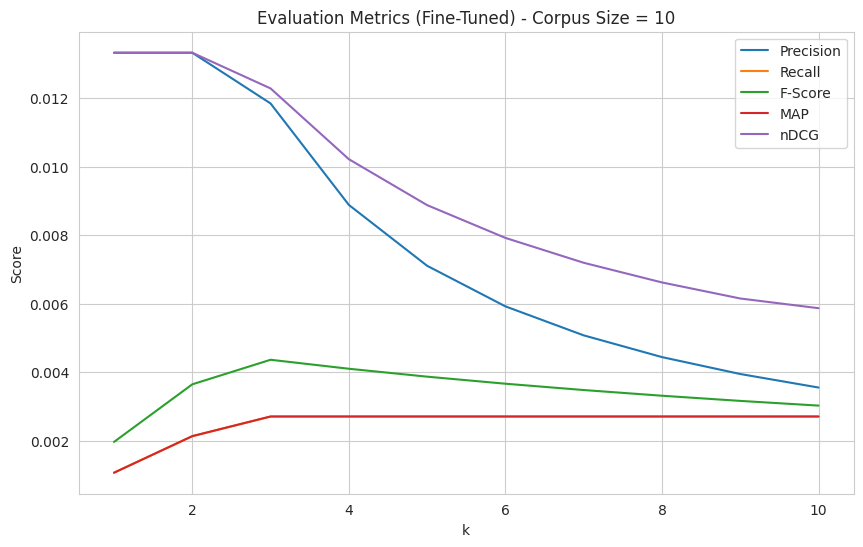

Evaluating Fine-Tuned IR for Varying Corpus Sizes:  17%|█▋        | 1/6 [00:01<00:06,  1.25s/it]


=== Corpus Size: 50 ===


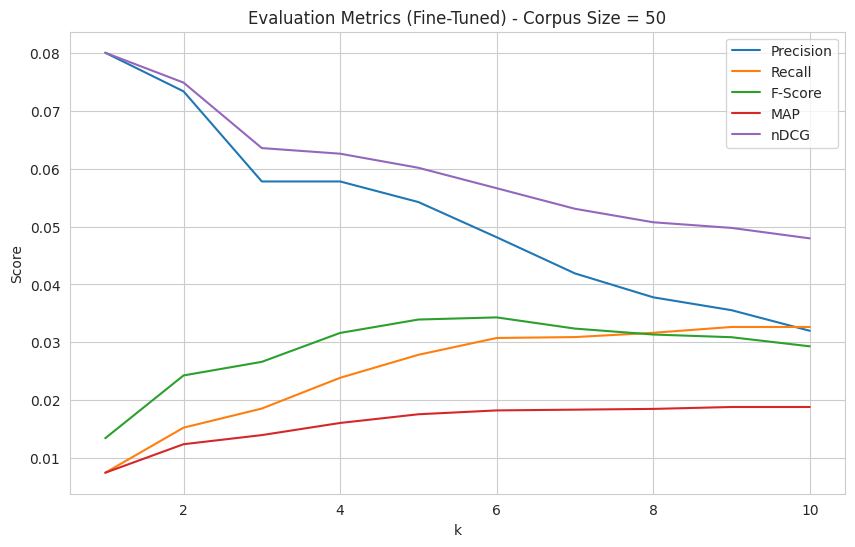

Evaluating Fine-Tuned IR for Varying Corpus Sizes:  33%|███▎      | 2/6 [00:02<00:05,  1.26s/it]


=== Corpus Size: 100 ===


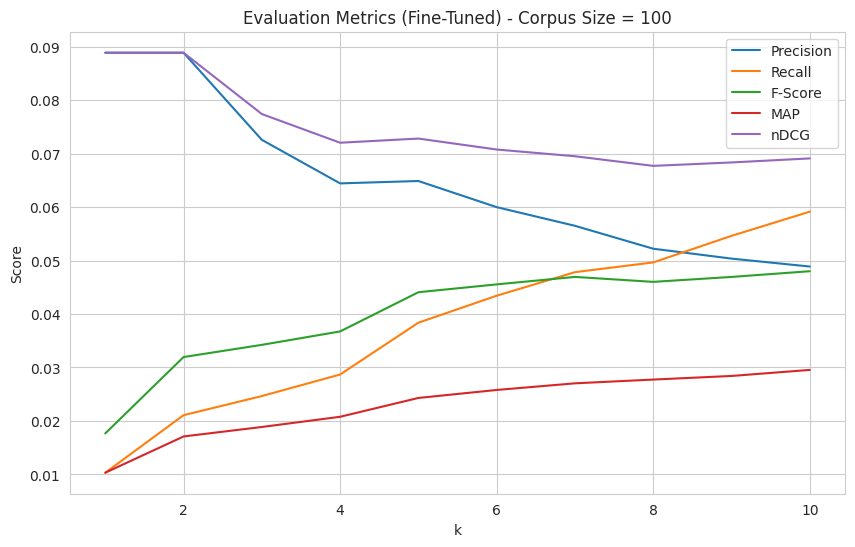

Evaluating Fine-Tuned IR for Varying Corpus Sizes:  50%|█████     | 3/6 [00:03<00:03,  1.29s/it]


=== Corpus Size: 200 ===


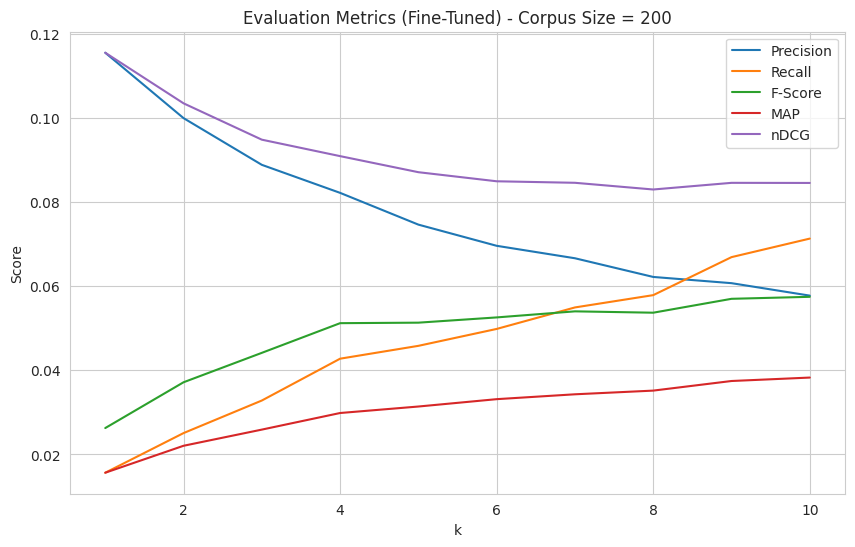

Evaluating Fine-Tuned IR for Varying Corpus Sizes:  67%|██████▋   | 4/6 [00:04<00:02,  1.18s/it]


=== Corpus Size: 400 ===


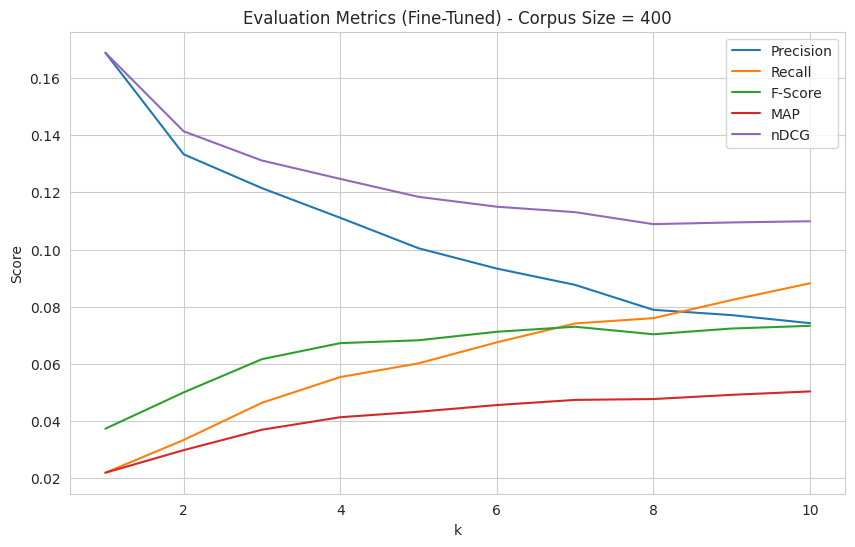

Evaluating Fine-Tuned IR for Varying Corpus Sizes:  83%|████████▎ | 5/6 [00:06<00:01,  1.39s/it]


=== Corpus Size: 1500 ===


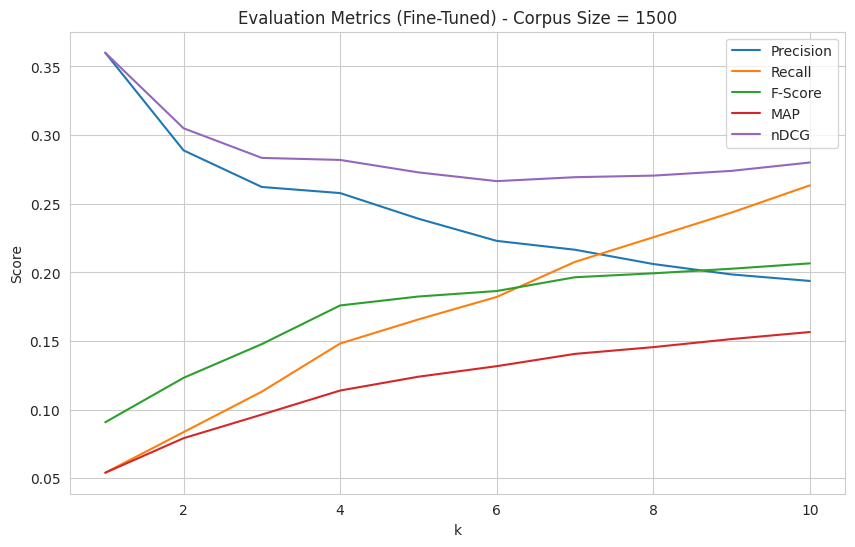

Evaluating Fine-Tuned IR for Varying Corpus Sizes: 100%|██████████| 6/6 [00:10<00:00,  1.79s/it]


In [29]:
import json
import numpy as np
import nltk
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm



if __name__ == "__main__":
    corpus_sizes = [10, 50, 100, 200, 400, 1500]

    # Create a directory for output plots if it does not exist:
    if not os.path.exists("glove"):
        os.makedirs("glove")

    for corpus_size in tqdm(corpus_sizes, desc="Evaluating Fine-Tuned IR for Varying Corpus Sizes"):
        print(f"\n=== Corpus Size: {corpus_size} ===")

        # Instantiate the fine-tuned IR system:
        ft_ir = FineTunedInformationRetrieval(
            model=model,                    # your fine-tuned model (from training)
            word2idx=word2idx,              # vocabulary built during training
            corpus_file="ESA-for-IR/cranfield/cran_docs.json",
            corpus_size=corpus_size,
            max_len=150                 # for example, 100
        )

        # Load queries and qrels:
        queries_json = json.load(open("ESA-for-IR/cranfield/cran_queries.json", 'r'))
        qrels = json.load(open("ESA-for-IR/cranfield/cran_qrels.json", 'r'))

        # Extract query IDs and query texts:
        query_ids = [item["query number"] for item in queries_json]
        queries = [item["query"] for item in queries_json]

        # Build a qrels dictionary mapping query numbers (as ints) to lists of relevant doc IDs:
        qrel_dict = {}
        for q in qrels:
            qrel_dict.setdefault(int(q["query_num"]), []).append(str(q["id"]))

        # For each query, get the ranked document IDs using the fine-tuned model:
        doc_IDs_ordered = [ft_ir.rank(query)[0] for query in queries]

        # Initialize lists for evaluation metrics for cutoff values k=1,...,10.
        precisions, recalls, fscores, MAPs, nDCGs = [], [], [], [], []

        # Compute evaluation metrics at different cutoffs.
        for k in range(1, 11):
            relevant_docs = [qrel_dict.get(qid, []) for qid in query_ids]
            retrieved_docs_at_k = [doc_ids[:k] for doc_ids in doc_IDs_ordered]

            p_list, r_list, f_list, ap_list, ndcg_list = [], [], [], [], []

            for i, (retrieved, relevant) in enumerate(zip(retrieved_docs_at_k, relevant_docs)):
                rel_set = set(relevant)
                retrieved_set = set(retrieved)
                true_positives = len(rel_set & retrieved_set)

                # Debug info if necessary.
                if true_positives == 0 and corpus_size == 10:
                    print(f"\nQuery {i+1}:")
                    print(f"Retrieved: {retrieved}")
                    print(f"Relevant : {relevant}")
                    print("⚠️ No true positives.")

                precision = true_positives / len(retrieved) if retrieved else 0
                recall = true_positives / len(rel_set) if rel_set else 0
                f = (2 * precision * recall) / (precision + recall) if precision + recall else 0

                # Calculate Average Precision (AP)
                ap = 0.0
                hits = 0
                for j, doc_id in enumerate(retrieved):
                    if doc_id in rel_set:
                        hits += 1
                        ap += hits / (j + 1)
                ap /= len(rel_set) if rel_set else 1

                # Calculate nDCG
                dcg = sum([1 / np.log2(j + 2) if retrieved[j] in rel_set else 0 for j in range(len(retrieved))])
                idcg = sum([1 / np.log2(j + 2) for j in range(min(len(rel_set), k))])
                ndcg = dcg / idcg if idcg > 0 else 0

                p_list.append(precision)
                r_list.append(recall)
                f_list.append(f)
                ap_list.append(ap)
                ndcg_list.append(ndcg)

            precisions.append(np.mean(p_list))
            recalls.append(np.mean(r_list))
            fscores.append(np.mean(f_list))
            MAPs.append(np.mean(ap_list))
            nDCGs.append(np.mean(ndcg_list))

        # Plot the evaluation metrics vs k (from 1 to 10):
        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")
        plt.plot(range(1, 11), precisions, label="Precision")
        plt.plot(range(1, 11), recalls, label="Recall")
        plt.plot(range(1, 11), fscores, label="F-Score")
        plt.plot(range(1, 11), MAPs, label="MAP")
        plt.plot(range(1, 11), nDCGs, label="nDCG")
        plt.legend()
        plt.title(f"Evaluation Metrics (Fine-Tuned) - Corpus Size = {corpus_size}")
        plt.xlabel("k")
        plt.ylabel("Score")
        plt.savefig(f"glove/eval_plot_finetuned_{corpus_size}.png")
        plt.show()
